# model_v7_pesos

En el "model_v7_pesos", se entrena una red neuronal por medio de __Transfer Learning__.

Red neuronal base: 'mobilenet_v3_large_100_224'.

Se aplican pesos en el entrenamiento del modelo para compensar el desbalance de datos en las distintas categorías.

Con epoch: 5 > __Recall__: 90,1%

In [8]:
# Funciones
# ================================================================================================================================
import os, sys
sys.path.insert(1, r'C:\Users\gonza\OneDrive\Escritorio\Bootcamp_DS\Alumno\ds_thebridge_1_22\3-Machine_Learning\Entregas\utils')
from funciones import procesamiento_de_datos_X, procesamiento_de_datos_y, define_x_y, contar_imagenes
from funciones import plot_cm, metricas, plot_roc_curve

# Tratamiento de datos
# ==============================================================================
import os
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Tratamiento de imágenes
# ==============================================================================
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from keras import regularizers  
from keras import layers
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization

# Evaluación del modelo
# ==============================================================================
from sklearn.metrics import confusion_matrix

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# 1. Procesamiento de datos
==================================================================================================

In [3]:
path_train = '../data/processed/train'
path_val = '../data/processed/val'
path_test = '../data/processed/test'
tipos = os.listdir(path_train)

In [4]:
# Definimos variables
X_train, y_train = define_x_y(path_train)
X_val, y_val = define_x_y(path_val)
X_test, y_test = define_x_y(path_test)

In [5]:
# Procesamiento de datos
X_train, X_val, X_test = procesamiento_de_datos_X(X_train, X_val, X_test)
y_train, y_val, y_test = procesamiento_de_datos_y(y_train, y_val, y_test)

### Definición de los pesos

In [6]:
summary_y_train = contar_imagenes(path_train, tipos)

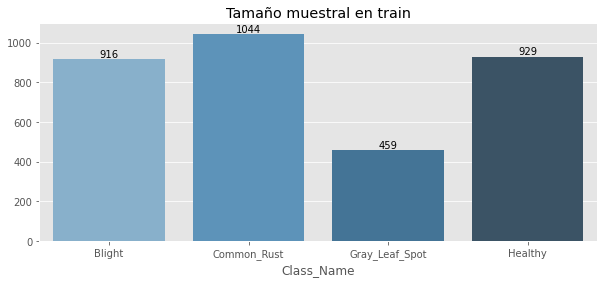

In [9]:
plt.figure(figsize=(10,4))
ax = sns.barplot(x=summary_y_train.iloc[:,0], y=summary_y_train.iloc[:,1], palette='Blues_d')
plt.title('Tamaño muestral en train')
plt.ylabel('', fontsize=18)
ax.bar_label(ax.containers[0]);

Vemos que el target está desbalanceado ligeramente

Para lograr un modelo que genelarice bien, __es fundamental compensar este desequilibrio__. De lo contrario, un modelo de ML tenderá a ignorar las muestras minoritarias, y por tanto tener un rendimiento menor cuando haya que etiquetarlas.

En este caso, los datos están desproporcionados ligeramente, especialemnte contamos con una minoría clara: 'Gray-Leaf_Spot'. Aplicaremos pesos si mejora el rendimiento de nuestro modelo.

In [10]:
summary_y_train['actual_weight'] = summary_y_train['No of Images'] / summary_y_train['No of Images'].sum()
summary_y_train['weight'] = 1 / (summary_y_train['No of Images'] / summary_y_train['No of Images'].max())

summary_y_train

,Class_Name,No of Images,actual_weight,weight
0,Blight,916,0.273596,1.139738
1,Common_Rust,1044,0.311828,1.000000
2,Gray_Leaf_Spot,459,0.137097,2.274510
3,Healthy,929,0.277479,1.123789


In [11]:
# {'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}
class_weights = {i : summary_y_train['weight'][i] for i in range(len(summary_y_train))}  
class_weights

{0: 1.1397379912663756, 1: 1.0, 2: 2.2745098039215685, 3: 1.123789020452099}

# 2. Definición del modelo
==================================================================================================

El modelo __Sequential__ es la forma más fácil de construir un modelo en Keras, una interfaz para la librería TensorFlow. Con este modelo iremos capa por capa, agregándolas mediante la función 'add()'.

## Transfer Learning

Vamos a utilizar como capa de entrada una red neuronal ya entrenada previamente por expertos, disponibles al público en __[TensorFlow Hub](https://tfhub.dev/)__.

In [15]:
# TRANSFER LEARNING: Vamos a utilizar como primeras capas una red neuronal ya entrenada previamente por expertos

base_model = Sequential(
    [hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
                   trainable=False),
    tf.keras.layers.Dense(len(tipos), activation='softmax')
    ])


In [16]:
# define loss and optimizer
base_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 3. Entrenamiento del modelo
==================================================================================================

In [17]:
# fit the model
base_model.fit(X_train, y_train, 
                    epochs=5, 
                    batch_size=128, 
                    verbose=2, 
                    class_weight=class_weights
                    )

Epoch 1/5
27/27 - 56s - loss: 0.9010 - accuracy: 0.7189 - 56s/epoch - 2s/step
Epoch 2/5
27/27 - 52s - loss: 0.3968 - accuracy: 0.8952 - 52s/epoch - 2s/step
Epoch 3/5
27/27 - 52s - loss: 0.3196 - accuracy: 0.9208 - 52s/epoch - 2s/step
Epoch 4/5
27/27 - 58s - loss: 0.2776 - accuracy: 0.9322 - 58s/epoch - 2s/step
Epoch 5/5
27/27 - 62s - loss: 0.2519 - accuracy: 0.9421 - 62s/epoch - 2s/step


In [18]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              4226432   
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 4,231,556
Trainable params: 5,124
Non-trainable params: 4,226,432
_________________________________________________________________


### Guardamos el modelo

In [22]:
# Vamos a guardar nuestro modelo
if '../model/model_v7_pesos' not in os.listdir():
    base_model.save('../model/model_v7_pesos')

INFO:tensorflow:Assets written to: model_v10\assets


INFO:tensorflow:Assets written to: model_v10\assets


In [12]:
# Lo podemos llamar cuando queramos
reconstructed_model = keras.models.load_model('../model/model_v7_pesos')

# 4. Evaluación del modelo
==================================================================================================

In [14]:
metricas(y_test, reconstructed_model.predict(X_test))

Accuracy: 0.901
Precision: 0.909
Recall: 0.901


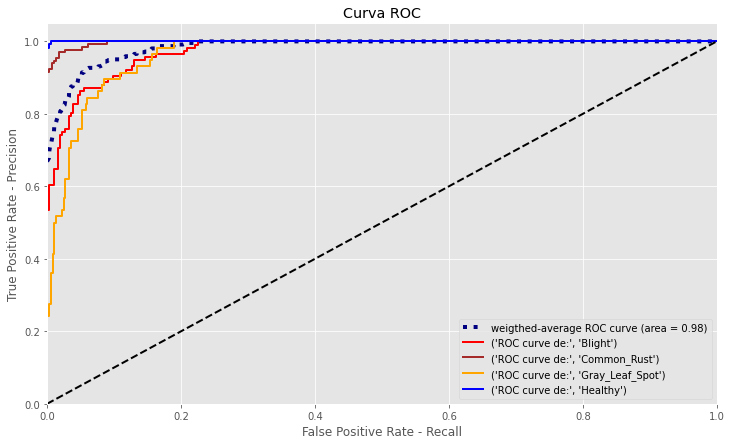

In [15]:
plot_roc_curve(y_test, reconstructed_model.predict(X_test))

In [16]:
# De un vistazo, matriz de confusión
cm = confusion_matrix(y_test, np.argmax(reconstructed_model.predict(X_test), axis=1))
cm_dec = [ cm[i] / np.sum(cm[i]) for i in range(len(cm))]
cm_per = [ [ str(round(x*100,1))+"%" for x in my_list] for my_list in cm_dec ]
cm_per

[['80.2%', '2.6%', '16.4%', '0.9%'],
 ['3.0%', '93.9%', '3.0%', '0.0%'],
 ['13.8%', '1.7%', '82.8%', '1.7%'],
 ['0.0%', '0.0%', '0.9%', '99.1%']]

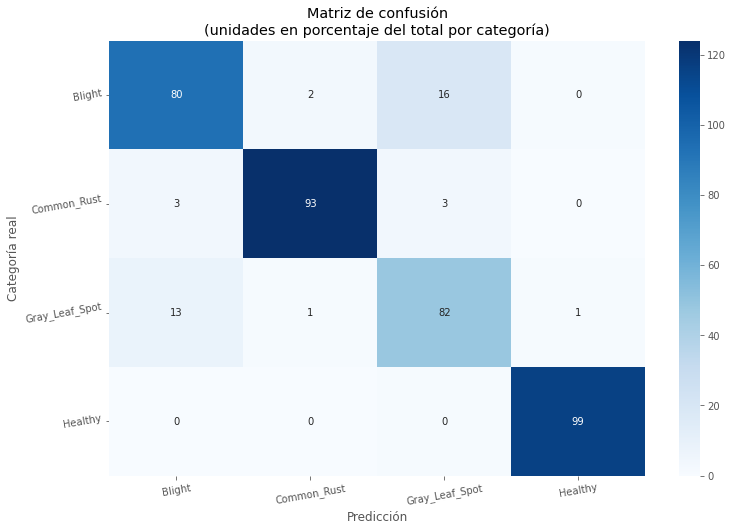

In [17]:
plot_cm(y_test, np.argmax(reconstructed_model.predict(X_test),axis=1))